# Stochastic Gradient Descent

Consider a function that depends on a number of variables $\vec{x}$ and parameters ${\bf w}$,
$$
f_{ {\bf w} }(\vec{x} ) \;,
$$
with the parameters not only affecting the values of the function but  **defining** it (e.g. consider $f_{a}(x) = x^a$).  Consider also another function that depends on $f_{\bf w}$, but not $\vec{x}$ (e.g. by averaging over $\vec{x}$), i.e. $E[f_{\bf w}]$. How do we minimize $E[f_{\bf w}]$? This can be done by taking  $E({\bf w})=E[f_{\bf w}]$, and using (for example) *Gradient Descent* (GD) to find ${\bf w}$ that minimize $E$.

In the case of $E[f_{\bf w}] = \dfrac{1}{n}\displaystyle \sum_{i=0}^{n} Q[ f_{\bf w}(\vec{x}_i)]$, GD becomes (in principle) very expensive as $n \to \infty$, as the parameters are updated using 
$$
{\bf w}^{\prime} = {\bf w} - \alpha {\bf \nabla}_{\bf w} E[f_{\bf w}] \Rightarrow \\
%
{\bf w}^{\prime} = {\bf w} - \dfrac{\alpha}{n} {\bf \nabla}_{\bf w} \displaystyle\sum_{i}^{n} Q[f_{\bf w}(\vec{x})_i] \; ,
$$
i.e. we need to compute the sum at each step. 

However, instead of computing the sum at each step, we can randomly choose a point $\vec{x}_i$, and update ${\bf w}$ using
$$
{\bf w}^{\prime} = {\bf w} - \alpha {\bf \nabla}_{\bf w} Q[f_{\bf w}(\vec{x})_i] \; .
$$
This is the *Stochastic Gradient Descent* (SGD) algorithm. The idea here is that after $N$ updates, as $N \to \infty$, the steps converge to $\Delta{\bf w}= - \dfrac{\alpha}{N} \displaystyle\sum_{i}^{N}{\bf \nabla}_{\bf w} Q[f_{\bf w}(\vec{x})_i] \approx -\alpha {\bf \nabla}_{\bf w} E[f_{\bf w}]$.


Let's see how it works, by constructing a class!


In order to make it consistent  with the GD algorithm, we will use the definition
$$
Q[f_{\bf w}(\vec{x})] \equiv Q(\vec{x};{\bf w}) \;,
$$
which results to (the $t^{\rm th}$ update)
$$
{\bf w}^{(t+1)} = {\bf w}^{(t)} - \alpha {\bf \nabla}_{\bf w} Q(\vec{x}_i;{\bf w}^{(t)}) \;,
$$
for $\vec{x}_i$ random from $\{\vec{x}_1, \vec{x}_2, \dots ,\vec{x}_n \}$.


# AdaDelta


One of the things that can make SGD unable to converge, is the learning rate, which has to be tunned. This can be avoided by using *AdaDelta* [[1212.5701](https://arxiv.org/abs/1212.5701)] that tries to adjust the learning as the algorithm proceeds. 

The update of ${\bf w}$, according to this is: 

$$
{\bf w}^{(t)} = {\bf w}^{(t-1)} - \delta {\bf w}^{(t)}  \;,
$$
with
$$
\delta {\bf w}^{(t)} = \dfrac{\sqrt{ \mathbb{E}[\delta {\bf w}^2]^{(t-1)} + \epsilon}  }{\sqrt{ \mathbb{E}[g^2]^{(t)} + \epsilon}} {\bf \nabla}_{\bf w} Q(\vec{x}_i;{\bf w}^{(t-1)}) \;, 
$$
where the *decaying averages* are
$$
\mathbb{E}[\delta {\bf w}^2]^{(t)} \equiv \gamma \ \mathbb{E}[\delta {\bf w}^2]^{(t-1)} +
(1-\gamma) \ \left( \delta {\bf w}^{(t)} \right)^2 \;, 
\\
\mathbb{E}[g^2]^{(t)} \equiv \gamma \ \mathbb{E}[g^2]^{(t-1)} +
(1-\gamma) \ \left( {\bf \nabla}_{\bf w} Q(\vec{x}_i;{\bf w}^{(t-1)}) \right) \cdot \left( {\bf \nabla}_{\bf w} Q(\vec{x}_i;{\bf w}^{(t-1)}) \right)\;, 
$$
for $\mathbb{E}[X]^{(0)} = 0$. 

The parameters $\gamma$ and $\epsilon$ are free, but generally $\gamma \approx 1$ and $\epsilon \ll 1$. Common choice is $\gamma \approx 0.95$ and $\epsilon \ll 10^{-6}$.

### The algorithm

With these definitions, the AdaDelta algorithm is:

1. Initialize $\mathbb{E}[g^2]^{(0)} =0$ and $\mathbb{E}[\delta {\bf w}^2]^{(0)}=0$
1. Loop t=1,2,...  until some condition is satisfied
    1. Calculate ${\bf \nabla}_{\bf w} Q(\vec{x}_i;{\bf w}^{(t-1)})$
    1. Accumulate $\mathbb{E}[g^2]^{(t)}$
    1. Calculate $\delta {\bf w}^{t} = \dfrac{\sqrt{ \mathbb{E}[\delta {\bf w}^2]^{(t-1)} + 
    \epsilon}  }{\sqrt{ \mathbb{E}[g^2]^{(t)} + \epsilon}} {\bf \nabla}_{\bf w} Q(\vec{x}_i;{\bf w}^{(t-1)})$
    1. Accumulate $\mathbb{E}[\delta {\bf w}^2]^{(t)}$
    1. Update ${\bf w}^{(t+1)} = {\bf w}^{(t)} - \delta {\bf w}^{(t)}$  
1. Done

---

## RMSprop

There is a variant of AdaDelta called *RMSprop*, which uses
$$
\delta {\bf w}^{(t)} = \dfrac{\alpha}{\sqrt{ \mathbb{E}[g^2]^{(t)} + \epsilon}} {\bf \nabla}_{\bf w} Q(\vec{x}_i;{\bf w}^{(t-1)}) \;, 
$$
with $\alpha \ll 1$ some constant (typically $\alpha  =10^{-3}$).


In [1]:
import numpy as np


import matplotlib
matplotlib.use('nbAgg')
import matplotlib.pyplot as plt

In [2]:
class modelBase:
    '''
    This is how the function should look like.
    The key point is to have way to update the parameters w.
    '''
    def __init__(self,dimensions,w0):
        '''
        func: the function that depends on parameters w
        dfdw_i: the derivative wrt w_i (see self.derivative_w to see how it should be defined).
        dimensions:list  [inpunt_dim,output_dim]
        w0: initial values of w
        '''
    
        self.w=w0
        self.dim=len(w0)
        
        self.dimensions=dimensions
        
        self.signal=[0 for i in range(dimensions[1])] #will store the output of self.f
        self.dsdw=[0 for i in range(dimensions[1])] #will store the output of self.dfdw_i
        
        #will store the input, to avoid passing the input every time we callthe function or its derivetive
        self.input=[0 for i in range(dimensions[1])]
    
    def setInput(self,x):
        '''set the input'''
        self.input=x

    def __call__(self):
        pass
    
    def derivative_w(self,i):
        pass

In [3]:
class lossFunc:
    '''
    This is how the loss function should look like.
    We use a class, in order to encapsulate the gradient within the same object.
    '''
    def __init__(self,data_in,data_out,Q_i,dQds_i,model):
        '''
        data_in, data_out: the input, output data to be used in order to minimize the loss
        
        Q: the loss function in one domension. It will be averaged over all dimensions in __call__
        dQds_i: the derivative of the loss function wrt to s_i (the i^th signal)
        
        model: instance of modelFunc 
        '''
        self.data_in=data_in
        self.data_out=data_out
        self.data_size=len(self.data_in)
        
        self.Q_i=Q_i
        self.dQds_i=dQds_i
        self.model=model
        
        self.dim=len(self.model.w)#dimension of w
        self.N=model.dimensions[1]#dimension of model.signal
        self.dQdw=0 #this will hold dQdw
        self.t=[]
        
        
    def __call__(self,target):
        sum_Q=0;
         
        for r in range(self.N):
            sum_Q+=self.Q_i(self.model.signal[r],target[r])
    
        sum_Q=sum_Q/(float(self.N))

        return sum_Q
    
    def randomDataPoint(self):
        index=np.random.randint(self.data_size)
        self.t=self.data_out[index]    
        self.model.setInput(self.data_in[index])
        self.model()

    
    
    def grad(self,i):
        self.model.derivative_w(i)
        self.dQdw=0
        
        for r in range(self.N):
            tmp_dQds=self.dQds_i(self.model.signal[r], self.t[r])/(float(self.N))
            self.dQdw += tmp_dQds*self.model.dsdw[r]



In [4]:
class StochasticGradientDescent:    
    def __init__(self,loss):
        '''
        loss: the loss function
        '''
        
        self.Q=loss
    
        
        self.steps=[]
        self.steps.append(self.Q.model.w[:])
        self.dim=self.Q.model.dim

    def update(self):
        pass
    
    def run(self,abs_tol=1e-5, rel_tol=1e-3, step_break=100,max_step=5000):
        '''        
        abs_tol, rel_tol, step_break: stop when _check<1 (_check is what update should return) 
        for step_break consecutive steps
        
        max_step: maximum number of steps
        '''
        _s=0
        count_steps=1
        while count_steps<=max_step:
            _check=self.update(abs_tol, rel_tol)
            
            count_steps+=1             
                
            
            if _check<1:
                _s+=1
            else:
                _s=0
            
            if _s>step_break:
                break

        return self.Q.model.w[:]

In [5]:
class VanillaSGD(StochasticGradientDescent):
    '''Plain SGD, with constant learning rate'''
    
    def __init__(self,loss,alpha=1e-2):
        '''
        loss: the loss function
        alpha: the learning rate
        '''
        StochasticGradientDescent.__init__(self,loss)
        self.alpha=alpha


    def update(self,abs_tol=1e-5, rel_tol=1e-3):
        '''
        update should return a number that when it is smaller than 1
        the main loop stops. Here I choose this number to be:
        sqrt(1/dim*sum_{i=0}^{dim}(grad/(abs_tol+x*rel_tol))_i^2)
        '''
        
        self.Q.randomDataPoint()
        
        _w2=0
        _check=0
        for i in range(self.dim):
            self.Q.grad(i)
            dw=self.alpha*self.Q.dQdw
            self.Q.model.w[i]=self.Q.model.w[i]-dw
            
            _w2=abs_tol + np.abs(self.Q.model.w[i]) * rel_tol
            _check+=(dw/_w2)*(dw/_w2)

        _check=np.sqrt(1./self.dim *_check)
        
        self.steps.append(self.Q.model.w[:])
        
        
        return _check

In [6]:
class RMSpropSGD(StochasticGradientDescent):
    '''Implementation of RMSprop.'''

    def __init__(self,loss,gamma=0.95,epsilon=1e-6,alpha=1e-3):
        '''
        loss: the loss function
        gamma: the decaying parameter
        epsilon: safety parameter (to avoid division by 0)
        alpha: learning rate
        '''
        
        StochasticGradientDescent.__init__(self,loss)
        self.gamma=gamma
        self.epsilon=epsilon
        self.alpha=alpha
        
        # counters for the decaying means of the gradient and dw         
        self.gE=[0 for _ in self.Q.model.w]
        

    def update(self,abs_tol=1e-5, rel_tol=1e-3):
        '''
        update should return a number that when it is smaller than 1
        the main loop stops. Here I choose this number to be:
        sqrt(1/dim*sum_{i=0}^{dim}(grad/(abs_tol+x*rel_tol))_i^2)
        '''
        self.Q.randomDataPoint()
        
        _w2=0
        _check=0
        for i in range(self.dim):
            self.Q.grad(i)
            
            self.gE[i]=self.gamma*self.gE[i] + (1-self.gamma)*self.Q.dQdw**2 
            dw=self.alpha/np.sqrt( (self.gE[i]+self.epsilon)  )*self.Q.dQdw
            
            
            self.Q.model.w[i]=self.Q.model.w[i] - dw
            
            
            _w2=abs_tol + np.abs(self.Q.model.w[i]) * rel_tol
            _check+=(dw/_w2)*(dw/_w2)

        _check=np.sqrt(1./self.dim *_check)
        self.steps.append(self.Q.model.w[:])
        
        return _check

In [7]:
class AdaDeltaSGD(StochasticGradientDescent):
    '''Implementation of AdaDelta.'''
    
    def __init__(self,loss,gamma=0.95,epsilon=1e-6,alpha=1):
        '''
        loss: the loss function
        gamma: the decaying parameter
        epsilon: safety parameter (to avoid division by 0)
        '''
        StochasticGradientDescent.__init__(self,loss)
        self.gamma=gamma
        self.epsilon=epsilon
        self.alpha=alpha
        
        
        # counters for the decaying means of the gradient and dw         
        self.gE=[0 for _ in self.Q.model.w]
        self.dwE=[0 for _ in self.Q.model.w]
        
    def update(self,abs_tol=1e-5, rel_tol=1e-3):
        '''
        update should return a number that when it is smaller than 1
        the main loop stops. Here I choose this number to be:
        sqrt(1/dim*sum_{i=0}^{dim}(grad/(abs_tol+x*rel_tol))_i^2)
        '''
        self.Q.randomDataPoint()
        
        _w2=0
        _check=0
        for i in range(self.dim):
            self.Q.grad(i)
            
            self.gE[i]=self.gamma*self.gE[i] + (1-self.gamma)*self.Q.dQdw**2 
            dw=np.sqrt( (self.dwE[i]+self.epsilon)/(self.gE[i]+self.epsilon)  )*self.Q.dQdw*self.alpha
            
            self.dwE[i]=self.gamma*self.dwE[i] + (1-self.gamma)*dw**2
            
            self.Q.model.w[i]=self.Q.model.w[i] - dw
            
            
            _w2=abs_tol + np.abs(self.Q.model.w[i]) * rel_tol
            _check+=(dw/_w2)*(dw/_w2)

        _check=np.sqrt(1./self.dim *_check)
        
        self.steps.append(self.Q.model.w[:])
        
        return _check


# Example

Lets find $w_1$ and $w_2$ for $f(x) = x w_1+ w_2$ that fit with data taken from $t=2*x+3$.

Obviously the answer is $w_1 = 2$ and $w_2 = 3$.

In [8]:
data_in=[]
data_out=[]
xmin=-5
xmax=2
for i in range(5000):
    x=np.random.rand()*(xmax-xmin)+xmin
    
    data_in.append( [x])
    data_out.append( [2*x+3])


In [9]:
class modelFunc(modelBase):
    def __init__(self,dimensions,w0):
        modelBase.__init__(self,dimensions,w0)
        
        
    def __call__(self):
        self.signal[0]=self.input[0]*self.w[0]+ self.w[1]
        
        
    def derivative_w(self,i):
        if i==0:
            self.dsdw[0]=self.input[0]
        if i==1:
            self.dsdw[0]=1

In [10]:
#the squared error and its derivative
def Q_i(signal, target):
    return (signal-target)**2


def dQds_i(signal, target):
    return 2*(signal-target)

        
#declare the instances
model=modelFunc([1,1],[1,0.2])
Q=lossFunc(data_in,data_out,Q_i,dQds_i,model)

In [11]:

SGD=VanillaSGD(Q ,alpha=1e-2)
# SGD=RMSpropSGD(Q ,gamma=1-1e-2,epsilon=1e-5,alpha=1e-2)
# SGD=AdaDeltaSGD(Q ,gamma=0.99,epsilon=1e-5,alpha=1)

In [12]:
SGD.run(abs_tol=1e-5, rel_tol=1e-5, step_break=250,max_step=5000),len(SGD.steps)

([1.9999915341822558, 2.9999647361012722], 914)

<IPython.core.display.Javascript object>


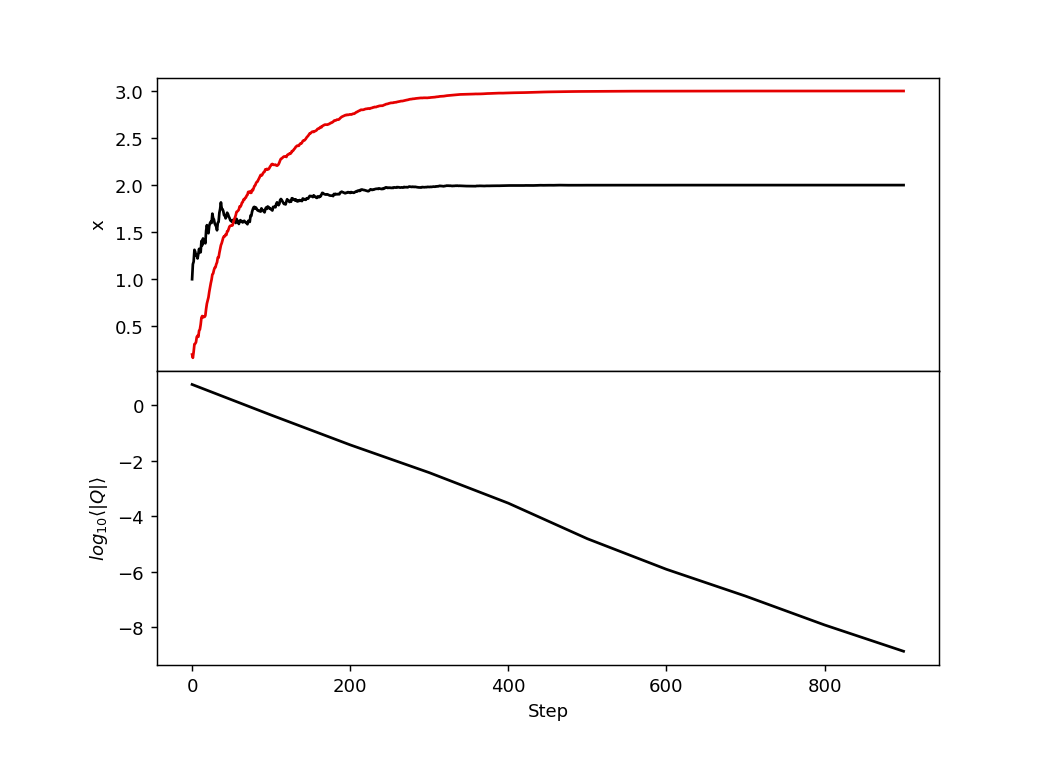

In [13]:
fig=plt.figure(figsize=(8,6))
fig.subplots_adjust(bottom=0.15, left=0.15, top = 0.9, right=0.9,wspace=0.1,hspace=0)
#=============================================================================#


sub = fig.add_subplot(211)
sub.get_xaxis().set_visible(False)

sub.plot(np.array(SGD.steps)[:,0],c='xkcd:black')
sub.plot(np.array(SGD.steps)[:,1],c='xkcd:red')

sub.set_ylabel('x')
# sub.set_xscale('log')
sub.set_yscale('linear')


sub = fig.add_subplot(212)
meanQ=[]
steps=[]
_s=0
skip=100
for w in SGD.steps[::skip]:
    model.w=w
    mQ=0
    _r=range(len(data_in))
    mC=50
    for _ in range(mC): 
        i=np.random.choice(_r)
        model.setInput(data_in[i])
        model()
        mQ+=np.abs( Q(data_out[i]) )
        
    if mQ==0:
        mQ=1e-50
    meanQ.append(np.log10(mQ/mC))
    steps.append(_s)
    _s+=skip
    
sub.plot(steps,meanQ,c='xkcd:black')

sub.set_ylabel(r'$log_{10} \langle |Q| \rangle $')

# sub.set_xscale('log')
sub.set_yscale('linear')

sub.set_xlabel('Step')

plt.show()